In [74]:
!pip install qiskit --quiet

In [75]:
!pip install pylatexenc --quiet

In [76]:
!pip install qiskit-ibm-runtime --quiet

In [77]:
!pip install qiskit-algorithms --quiet

In [78]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, PauliList
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Define the number of qubits
n = 2

# Define the single Pauli terms as ("Paulis", [indices], coefficient)
interactions = [("ZZ", [i, i + 1], 1) for i in range(n - 1)]  # Nearest-neighbor interaction
field = [("X", [i], -1) for i in range(n)]  # Local field

# Build the Hamiltonian operator
hamiltonian = SparsePauliOp.from_sparse_list(interactions + field, num_qubits=n)

# Define observables for XiXj, Xi, and Xj
XiXj_observables = [SparsePauliOp.from_list([("XX", [i, j])], num_qubits=n) for i in range(n) for j in range(i + 1, n)]
Xi_observables = [SparsePauliOp.from_list([("X", [i])], num_qubits=n) for i in range(n)]
Xj_observables = [SparsePauliOp.from_list([("X", [j])], num_qubits=n) for j in range(n)]


TypeError: must be real number, not list

In [ ]:
from qiskit import transpile
from qiskit.circuit.library import PauliEvolutionGate
import numpy as np

# Create a new circuit
qc = QuantumCircuit(n)

# Add initial state (e.g., all qubits in |0⟩ state)
qc.h(range(n))  # Apply Hadamard gate to all qubits

# Time evolution
T = 10
time_points = np.linspace(0, T, 100)

# Apply the evolution gate for each time step
sampler = Sampler()
results = []

for t in time_points:
    evo_gate = PauliEvolutionGate(hamiltonian, time=t)
    evolved_circuit = qc.copy()
    evolved_circuit.append(evo_gate, range(n))
    
    # Transpile for the backend
    transpiled_circuit = transpile(evolved_circuit, backend=backend)
    
    # Run the job on the simulator or real quantum device
    job = sampler.run(circuits=[transpiled_circuit], observables=XiXj_observables + Xi_observables + Xj_observables)
    result = job.result()
    
    results.append(result)


In [ ]:
import matplotlib.pyplot as plt

correlations = []

for i in range(len(time_points)):
    xi_xj_expectation = results[i].quasi_distances[:len(XiXj_observables)]
    xi_expectation = results[i].quasi_distances[len(XiXj_observables):len(XiXj_observables) + len(Xi_observables)]
    xj_expectation = results[i].quasi_distances[len(XiXj_observables) + len(Xi_observables):]

    correlation = xi_xj_expectation - np.outer(xi_expectation, xj_expectation)
    correlations.append(correlation)

# Plot the correlation over time
plt.figure(figsize=(10, 6))
for idx in range(len(correlations[0])):
    plt.plot(time_points, [cor[idx] for cor in correlations], label=f'Correlation between qubit {idx}')

plt.xlabel('Time (s)')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.title('Correlation \(\langle X_iX_j \rangle - \langle X_i \rangle\langle X_j \rangle\) over Time')
plt.show()


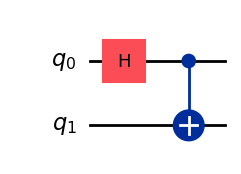

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

In [7]:
# Set up six different observables.
from qiskit.quantum_info import SparsePauliOp
 
observables_labels = ["IX", "XI", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [10]:
 
# Use the following code instead if you want to run on a simulator:
 
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()
estimator = Estimator(backend)
 
# Convert to an ISA circuit and layout-mapped observables.
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_result = job.result()[0]

/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/fake_backend.py:468: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(


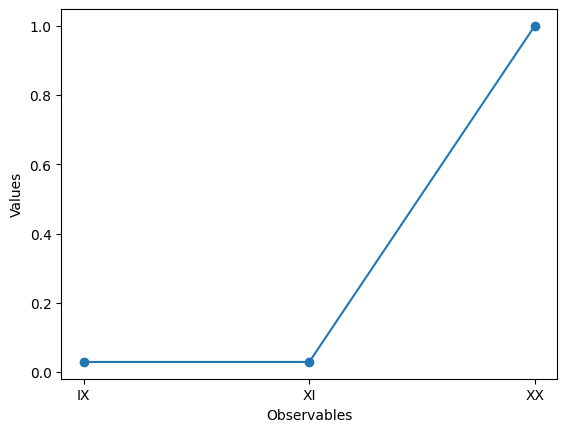

In [11]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()

# Constructing Hamiltonians

In [79]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from matplotlib import pyplot as plt

In [80]:
## Hamiltonian Construction
n = 2 
interactions_X = [("XX", [i, i + 1], 1) for i in range(n - 1)]  
interactions_Y = [("YY", [i, i + 1], 1) for i in range(n - 1)]  
hamiltonian = SparsePauliOp.from_sparse_list(interactions_X + interactions_Y, num_qubits=n)

In [82]:
# ## Set of Observables whose expval needs to be computed
# observables_labels = ["IX", "XI", "XX"]
# observables = [SparsePauliOp(label) for label in observables_labels]
# print(observables)

[SparsePauliOp(['IX'],
              coeffs=[1.+0.j]), SparsePauliOp(['XI'],
              coeffs=[1.+0.j]), SparsePauliOp(['XX'],
              coeffs=[1.+0.j])]


In [ ]:
magnetization_op = SparsePauliOp.from_sparse_list(
    [("X", [i], 1.0) for i in range(0, L)], num_qubits=L
)
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) 

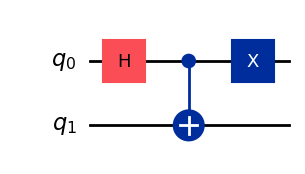

<IPython.core.display.Latex object>

In [62]:
final_time = 10
## First spin up, second spin down
## (remember that the labels are interpreted from right to left)
sv1 = Statevector.from_label('00') # start with |00>

mycircuit1 = QuantumCircuit(2)
mycircuit1.h(0)
mycircuit1.cx(0,1)

mycircuit1.x(0) # apply x gate after CNOT

new_sv1 = sv1.evolve(mycircuit1)
display(mycircuit1.draw('mpl'))
display(new_sv1.draw('latex'))

In [66]:
problem = TimeEvolutionProblem(hamiltonian, initial_state=new_sv1, time=final_time, aux_operators=[])

trotter = TrotterQRTE()
result = trotter.evolve(problem)

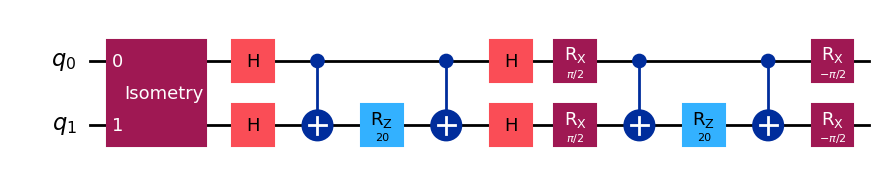

In [67]:
result.evolved_state.decompose(reps=2).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

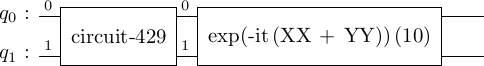

In [68]:
display(result.evolved_state.draw('latex'))

In [70]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([-1.58187870e-17+8.66340428e-17j,
              2.88557593e-01-6.45549778e-01j,
              2.88557593e-01-6.45549778e-01j,
             -1.58187870e-17+1.25886354e-16j],
            dims=(2, 2))


In [72]:
backend = FakeAlmadenV2()
estimator = Estimator(backend)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(result.evolved_state)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables]
 
job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/fake_backend.py:468: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(


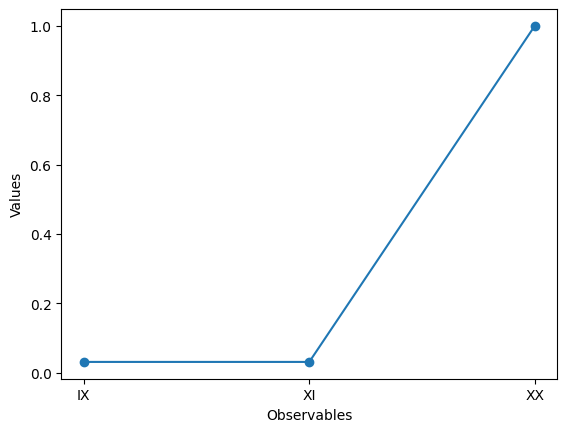

In [73]:
# Plot the result
values = pub_result.data.evs
errors = pub_result.data.stds 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()